# **Initializing**

Here we import the needed libraries, mount the drive and load the data (the images) into the notebook storage for quick access

### Imports

In [1]:
# imports
# !pip install torchvision
from torchvision import transforms, datasets, models, utils
import pandas as pd
import numpy as np
import subprocess
import random
from tqdm import tqdm



import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F


import PIL.Image
from PIL import Image
from torchvision.transforms.functional import resize, to_tensor, normalize

import zipfile
import copy
import time
import os
import torch
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

indexx = 0
plt.ion()   # interactive mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device_cpu = torch.device("cpu")


### paths and drive mount

In [2]:
mode = "Drive"
if mode == "Drive":
    """ Mount the drive """
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    path = '/content/drive/MyDrive/CenterCrop-Data'       # Path for the main project directory where the zipped data is saved
    csv_data = os.path.join('/content/drive/MyDrive/', 'Dataset_csv')          # Path for the folder containing the csv data

    train_path = "/content/train"
    test_path = "/content/test"
    model_save_path = os.path.join(csv_data, 'model_save')

elif mode == "pc":
    """ For PC use """
    path = ''
    csv_data = os.path.join(path, 'Dataset')
    train_path = "CenterCrop/train"
    test_path = "CenterCrop/test"
    model_save_path = os.path.join('DL', 'model')



Mounted at /content/drive


### Unzipping the data into root

In [3]:
train_zipped_path = os.path.join(path, 'train_cropped_data.zip')
test_zipped_path = os.path.join(path, 'test_cropped_data.zip')
extracted_train_dir_path = '/content/train'
extracted_test_dir_path = '/content/test'

# Create the directory if it doesn't exist
os.makedirs(extracted_train_dir_path, exist_ok=True)
os.makedirs(extracted_test_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(train_zipped_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_train_dir_path)
print("Train images extracted successfully.")

# Unzip the file
with zipfile.ZipFile(test_zipped_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_test_dir_path)
print("Test images extracted successfully.")

Train images extracted successfully.
Test images extracted successfully.


# **Building our Dataset class**

### PainterByNumbersDataset

In [4]:
""" Build our dataset class """

def get_rgb_img(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if img is None:
        print("image is None")
        img = io.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if len(img.shape) < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        print("Converted from GreyScale")
    elif img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        print("Converted from RGBA")
    return img


class PainterByNumbersDataset(Dataset):
    """ Painter By Numbers Dataset """

    def __init__(self, pair_csv_file, train_csv_file, data_path, root_dir, transform=None):
        """
        Arguments:
            pair_csv_file (string): Path to the csv file that contains pairs/triplets of images and their label.
            train_csv_file (string): Path to the csv file with data containing training image data and info.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        self.pairs_file = pd.read_csv(os.path.join(root_dir, pair_csv_file))
        self.data_file = pd.read_csv(os.path.join(root_dir, train_csv_file))
        self.data_path = data_path
        self.root_dir = root_dir
        self.transform = transform
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def __len__(self):
        return len(self.pairs_file)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.pairs_file.iloc[idx]

        anchor = row.loc["anchor"]
        positive = row.loc["positive"]
        negative = row.loc["negative"]

        try:
            done_image_1 = False
            done_image_2 = False

            anch = get_rgb_img(os.path.join(self.data_path, anchor))
            pos = get_rgb_img(os.path.join(self.data_path, positive))
            neg = get_rgb_img(os.path.join(self.data_path, negative))


            if self.transform:

                    anch = self.transform(anch)
                    done_image_1 = True
                    pos = self.transform(pos)
                    done_image_2 = True
                    neg = self.transform(neg)


        except Exception as e:
            print(f"Error occurred during training on batch !")
            print(f"Image 1 name: {anchor}")
            print(f"if image 1 is Done: {done_image_1}")
            print(f"size: {anch.shape}")
            print(f"Image 2 name: {positive}")
            print(f"if image 2 is Done: {done_image_1}")
            print(f"size: {pos.shape}")
            print(f"Image 3 name: {negative}")
            print(f"size: {neg.shape}")
            print(f"Error: {e}")

        sample = {"anchor": anch, 'positive': pos, 'negative': neg}

        return sample

### Showcase the dataset

In [5]:
new_csv_pairs_file = "train_triplets_with_labels_new.csv"
train_data_file = 'df_train_clean.csv'

dataset = PainterByNumbersDataset(new_csv_pairs_file, train_data_file, train_path, csv_data, transform=None)
data_size = len(dataset)
data_size

23755

#### a function that displays a grid of random samples from our dataset

In [6]:
def display_images_grid(dataset, num_rows):
    i = (3 * num_rows) + 1
    images = []
    row = []
    for _ in range(1, i, 1):
        sample_idx = random.randint(0, len(dataset))
        x = dataset[sample_idx]
        rgb_images = [cv2.cvtColor(x[key], cv2.COLOR_BGR2RGB) for key in ['anchor', 'positive', 'negative']]

        row.extend(rgb_images)
        if _ % 3 == 0:
            images.append(cv2.hconcat(row))
            row = []

    # Set the plot size
    plt.figure(figsize=(15, 14.5))
    # Display the concatenated image
    concatenated_image = cv2.vconcat(images)
    plt.imshow(concatenated_image, cmap=plt.cm.Spectral)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Samples of the data

In [7]:
display_images_grid(dataset, 10)

Output hidden; open in https://colab.research.google.com to view.

# **Transformations**



To help with the model's preformance and the best results we can we need to **augment the data** to help the model learng different parts of the image and most importantly help prevent overfitting.

**Therefore, we will need to write some more preprocessing code to help us augment and normalize the data.**

## Transformation functions

####Here are some transformations that we used to achive this


In [8]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # Convert from numpy array to PyTorch tensor
        # image = to_tensor(image)
        image = to_tensor(image).to(device)
        return image

class Normalize(object):
    """Normalize a tensor image with mean and standard deviation."""

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Normalize the tensor
        return normalize(tensor, mean=self.mean, std=self.std)

class RandomVerticalFlip(object):
    def __init__(self, p):
        self.vflipper = transforms.RandomVerticalFlip(p)

    def __call__(self, img):
        return self.vflipper(img)

class RandomHorizontalFlip(object):
    def __init__(self, p):
        self.hflipper = transforms.RandomHorizontalFlip(p)

    def __call__(self, img):
        return self.hflipper(img)

class RandomRotation(object):
    def __init__(self, degrees):
        self.rotater = transforms.RandomRotation(degrees=degrees)

    def __call__(self, img):
        return self.rotater(img)

class RandomAffine(object):
    def __init__(self, degrees, translate, scale, shear):
      self.affine_transfomer = transforms.RandomAffine(degrees=degrees, translate=translate, scale=scale, shear=shear)
    def __call__(self, img):
      return self.affine_transfomer(img)

class ColorJitter(object):
    def __init__(self, brightness, hue):
      self.jitter = transforms.ColorJitter(brightness=brightness, hue=hue)
    def __call__(self, img):
      return self.jitter(img)

class GaussianBlur(object):
    def __init__(self, kernel_size, sigma):
      self.blurrer = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)
    def __call__(self, img):
      return self.blurrer(img)
class RandomPerspective(object):
    def __init__(self, distortion, p):
      self.perspective_transformer = transforms.RandomPerspective(distortion_scale=distortion, p=p)

    def __call__(self, img):
      return self.perspective_transformer(img)

#### Here is a function used to print out a random sample to preview the transformations

In [9]:
def visualize_transformations(dataset, sample_idx):
    # Get the sample
    sample = dataset[sample_idx]
    tensor = transforms.ToTensor()
    # Define transformations
    transformations = [
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=45),
        transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=15),
        transforms.ColorJitter(brightness=0.2, hue=0.2),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
    ]

    # Plot original sample
    fig, axes = plt.subplots(9, 3, figsize=(15, 30))
    fig.tight_layout(pad=3.0)
    axes[0, 0].imshow(cv2.cvtColor(sample['anchor'], cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Anchor')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(cv2.cvtColor(sample['positive'], cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title('Original Positive')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(cv2.cvtColor(sample['negative'], cv2.COLOR_BGR2RGB))
    axes[0, 2].set_title('Original Negative')
    axes[0, 2].axis('off')

    # Apply transformations and plot
    for row, transform in enumerate(transformations, start=1):

        transformed_sample = {
            'anchor': transform(tensor(sample['anchor'])),
            'positive': transform(tensor(sample['positive'])),
            'negative': transform(tensor(sample['negative']))
        }

        # Convert tensor to numpy array
        transformed_sample = {key: tensor.permute(1, 2, 0).numpy() for key, tensor in transformed_sample.items()}

        transformed_sample = {key: cv2.cvtColor(tensor, cv2.COLOR_BGR2RGB) for key, tensor in transformed_sample.items()}

        axes[row, 0].imshow(transformed_sample['anchor'])
        axes[row, 0].set_title(f'Anchor transformed with {type(transform).__name__}')
        axes[row, 0].axis('off')

        axes[row, 1].imshow(transformed_sample['positive'])
        axes[row, 1].set_title(f'Positive transformed with {type(transform).__name__}')
        axes[row, 1].axis('off')

        axes[row, 2].imshow(transformed_sample['negative'])
        axes[row, 2].set_title(f'Negative transformed with {type(transform).__name__}')
        axes[row, 2].axis('off')

    plt.show()

sample_idx = random.randint(0, len(dataset) - 1)

## Showcase the  basic Transforms

In [10]:
visualize_transformations(dataset, sample_idx)

Output hidden; open in https://colab.research.google.com to view.

##Building a dataset with a combination of transformations

In [11]:
# Define our transformations
composed_train = transforms.Compose([
ToTensor(),
RandomVerticalFlip(0.5),
RandomHorizontalFlip(0.5),
RandomRotation(15),
ColorJitter(.5, .3),
RandomPerspective(0.6, 0.2),
# GaussianBlur((5, 9), (0.1, 5.)),
# RandomAffine((-15,15), (0,0),(0.8, 1.2), 10),
Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # Normalize the tensor

# composed_final = transforms.Compose([Rescale(256), RandomCrop(224), tensor, normalize])
transformed_dataset = PainterByNumbersDataset("train_triplets_with_labels_new.csv", 'df_train_clean.csv', train_path, csv_data, transform=composed_train)

composed_val_test = transforms.Compose([
ToTensor(),  # Convert image to tensor
# RandomHorizontalFlippp(0.5),
# RandomVerticalFlip(0.5),
# RandomRotation((0,15)),
# RandomAffine((30, 70), (0.1, 0.3), (0.5, 0.75)),
Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# **Network**

## Prep


### Data ratios and Dataloaders

In [12]:
""" a function taht dowsizes a dataset randomly to a specific percentage """
def downsize(csv_to_downsize, csv_new_name, percent):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(csv_data, csv_to_downsize))

    # Shuffle the rows of the DataFrame
    df_shuffled = df.sample(frac=1, random_state=42)

    # Calculate the number of rows to keep the percentage needed (in our case 42%)
    rows_to_keep = int(len(df_shuffled) * percent)

    # Keep the first 42% of rows
    df_downsized = df_shuffled.head(rows_to_keep)

    # Save the downsized DataFrame to a new CSV file
    df_downsized.to_csv(os.path.join(csv_data,csv_new_name), index=False)

    print(f"Downsizing complete. Saved to {csv_new_name}\n")
    return

In [13]:
""" Build our three datasets that we are going to use for our network """

# First of all we are going to Downsize our test data for a better ratio between our three datasets (we do this using our downsize function)
transformed_data_train = PainterByNumbersDataset("train_triplets_with_labels_new.csv", 'df_train_clean.csv', train_path, csv_data, transform=composed_train)
transformed_data_val = PainterByNumbersDataset("val_triplets_with_labels.csv", 'df_train_clean.csv', train_path, csv_data, transform=composed_val_test)
transformed_data_test = PainterByNumbersDataset("test_triplets_with_labels.csv", 'df_train_clean.csv', test_path, csv_data, transform=composed_val_test)

print("train dataset size: ", len(transformed_data_train))
print("val dataset size: ", len(transformed_data_val))
print("test dataset size: ", len(transformed_data_test))


train dataset size:  23755
val dataset size:  5996
test dataset size:  6135


In [14]:
""" Build the dataloaders for easy batching and ease of data access in general """
train_dataloader = torch.utils.data.DataLoader(transformed_data_train, batch_size=64, shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(transformed_data_val, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(transformed_data_test, batch_size=64, shuffle=True, num_workers=0)

dataset_sizes = {"train": len(transformed_data_train), "val": len(transformed_data_val), }


### Network defenition

In [15]:
""" Hyperparameters """
epochs = 15
margin = 5  # Margin for the loss function.

""" Tracking our model's stats """
accuracies = []
loss_dict = {"train": [], "val": [], 'test': []}
counter_dict = {"train": [], "val": [], 'test': []}

In [16]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model

        # Modify the last layer to output 512-dimensional embeddings
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 256).to(device)

    def forward(self, anchor, positive, negative):
        # Forward pass through the base model

        out1 = self.base_model(anchor)
        out2 = self.base_model(positive)
        out3 = self.base_model(negative)

        return  out1,  out2,  out3


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, label):
        # Calculate contrastive loss
        loss_contrastive = torch.mean((1-label) * torch.pow(output, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - output, min=0.0), 2))
        return loss_contrastive


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor_embdngs, positive_embdngs, negative_embdngs):
        distance_positive = F.pairwise_distance(anchor_embdngs, positive_embdngs, p=2)
        distance_negative = F.pairwise_distance(anchor_embdngs, negative_embdngs, p=2)
        loss = torch.mean(torch.clamp(distance_positive - distance_negative + self.margin, min=0.0))
        return distance_positive, distance_negative, loss

In [ ]:
# Initialize ResNet18 model from torchvision
resnet34 = models.resnet34(pretrained=True).to(device)

# Freeze all layers except the last convolutional layer
# for param in resnet18.parameters():
#     param.requires_grad = False
# resnet18.fc.requires_grad = True

# Initialize the Siamese Network
siamese_net = SiameseNetwork(resnet34).to(device)

# Initialize the contrastive loss function
criterion_contrastive = ContrastiveLoss(margin)
criterion_triplet = TripletLoss(margin)

# Initialize the optimizer
optimizer = Adam(siamese_net.parameters(), lr=0.000006)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)


### Plotting and testing functions

In [ ]:
def plot(loss_dict, counter_dict):
    # Plot train and test losses
    plt.figure(figsize=(9,5))
    plt.plot(counter_dict['train'], loss_dict['train'], color='blue', label='Train Loss')
    plt.plot(counter_dict['val'], loss_dict['val'], color='red', label='Val Loss')
    plt.plot(counter_dict['test'], loss_dict['test'], color='orange', label='Test Loss')
    plt.legend(['Train Loss', 'Val Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Train,Val & Test Losses')
    plt.grid(True)
    plt.show()

def plot_new(loss_dict, counter_dict):
    # Plot train and test losses
    plt.figure(figsize=(9,5))
    plt.plot(counter_dict['train'], loss_dict['train'], color='blue', label='Train Loss')
    plt.plot(counter_dict['val'], loss_dict['val'], color='red', label='Val Loss')
    # plt.plot(counter_dict['test'], loss_dict['test'], color='orange', label='Test Loss')
    plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Train & Val Losses')
    plt.grid(True)
    plt.show()


In [ ]:
def test_model(model, criterion):
    start = time.time()
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    running_corrects = 0
    for i, batch in enumerate(tqdm(test_dataloader)):
        anch, pos, neg = batch['anchor'], batch['positive'], batch['negative']
        anch, pos, neg = anch.cuda(), pos.cuda(), neg.cuda()

        with torch.no_grad():
            out1, out2, out3 = model(anch, pos, neg)

            distance_positive, distance_negative, loss = criterion(out1, out2, out3)

        running_loss += loss.item() * anch.size(0)
        running_corrects += torch.sum(distance_positive.squeeze() < distance_negative.squeeze())


    epoch_loss = running_loss / len(transformed_data_test)
    loss_dict['test'].append(epoch_loss)
    epoch_accuracy = running_corrects.double() /  len(transformed_data_test)
    print('\n{} Loss: {:.4f} Acc: {:.4f}%'.format("Test", epoch_loss, epoch_accuracy * 100))
    return epoch_accuracy, epoch_loss


## **Training The Model**

  **************************************** Epoch 1 ******************************************
Train: 


  0%|          | 1/372 [00:02<13:32,  2.19s/it]

Train Epoch: 1 [1/372 (0%)]	Loss: 4.50836


 13%|█▎        | 50/372 [01:09<07:15,  1.35s/it]

Train Epoch: 1 [50/372 (13%)]	Loss: 4.22942


 27%|██▋       | 100/372 [02:18<06:08,  1.35s/it]

Train Epoch: 1 [100/372 (27%)]	Loss: 3.90856


 40%|████      | 150/372 [03:28<05:24,  1.46s/it]

Train Epoch: 1 [150/372 (40%)]	Loss: 4.08244


 54%|█████▍    | 200/372 [04:35<03:50,  1.34s/it]

Train Epoch: 1 [200/372 (53%)]	Loss: 3.87574


 67%|██████▋   | 250/372 [05:43<02:41,  1.32s/it]

Train Epoch: 1 [250/372 (67%)]	Loss: 3.25068


 81%|████████  | 300/372 [06:52<01:39,  1.38s/it]

Train Epoch: 1 [300/372 (80%)]	Loss: 2.71430


 94%|█████████▍| 350/372 [08:01<00:30,  1.37s/it]

Train Epoch: 1 [350/372 (94%)]	Loss: 3.53547


100%|██████████| 372/372 [08:33<00:00,  1.38s/it]


Train Loss: 3.8435 Train Acc: 68.7097%

Validation: 


  1%|          | 1/94 [00:00<00:34,  2.70it/s]

Val Epoch: 1 [1/94 (0%)]	Loss: 3.18711


 53%|█████▎    | 50/94 [00:19<00:19,  2.21it/s]

Val Epoch: 1 [50/94 (52%)]	Loss: 3.66252


100%|██████████| 94/94 [00:35<00:00,  2.61it/s]


Val Loss: 3.0970 Val Acc: 74.1328%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:35<00:00,  2.71it/s]


Test Loss: 3.1653 Acc: 74.1320%


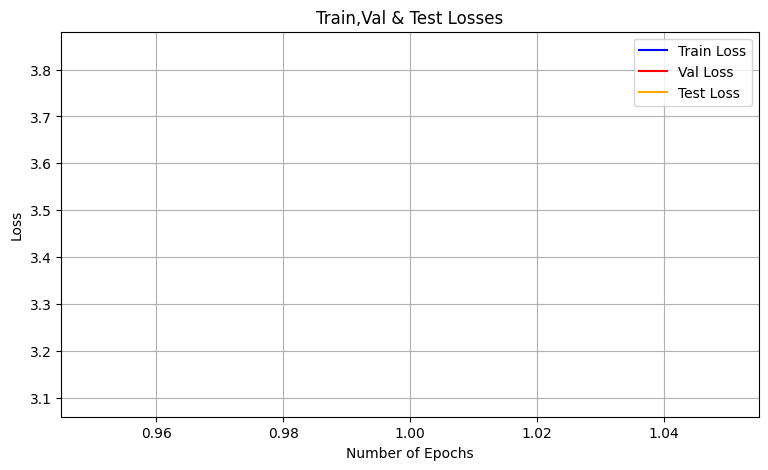

  **************************************** Epoch 2 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:45,  1.42s/it]

Train Epoch: 2 [1/372 (0%)]	Loss: 2.96791


 13%|█▎        | 50/372 [01:11<07:39,  1.43s/it]

Train Epoch: 2 [50/372 (13%)]	Loss: 3.23083


 27%|██▋       | 100/372 [02:26<06:09,  1.36s/it]

Train Epoch: 2 [100/372 (27%)]	Loss: 2.97960


 40%|████      | 150/372 [03:39<05:22,  1.45s/it]

Train Epoch: 2 [150/372 (40%)]	Loss: 2.61346


 54%|█████▍    | 200/372 [04:50<03:57,  1.38s/it]

Train Epoch: 2 [200/372 (53%)]	Loss: 2.29887


 67%|██████▋   | 250/372 [05:59<02:55,  1.44s/it]

Train Epoch: 2 [250/372 (67%)]	Loss: 2.48988


 81%|████████  | 300/372 [07:10<01:41,  1.41s/it]

Train Epoch: 2 [300/372 (80%)]	Loss: 3.29761


 94%|█████████▍| 350/372 [08:23<00:30,  1.41s/it]

Train Epoch: 2 [350/372 (94%)]	Loss: 2.26715


100%|██████████| 372/372 [08:52<00:00,  1.43s/it]


Train Loss: 2.9663 Train Acc: 74.8390%

Validation: 


  1%|          | 1/94 [00:00<00:33,  2.78it/s]

Val Epoch: 2 [1/94 (0%)]	Loss: 2.62289


 53%|█████▎    | 50/94 [00:17<00:15,  2.80it/s]

Val Epoch: 2 [50/94 (52%)]	Loss: 3.45362


100%|██████████| 94/94 [00:32<00:00,  2.86it/s]


Val Loss: 2.7574 Val Acc: 76.6845%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:35<00:00,  2.68it/s]


Test Loss: 2.8789 Acc: 75.4686%


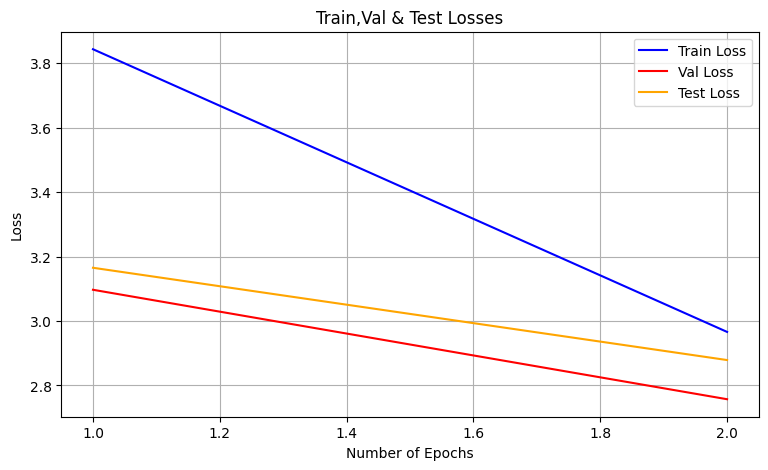

  **************************************** Epoch 3 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:35,  1.39s/it]

Train Epoch: 3 [1/372 (0%)]	Loss: 3.44897


 13%|█▎        | 50/372 [01:11<07:40,  1.43s/it]

Train Epoch: 3 [50/372 (13%)]	Loss: 2.64306


 27%|██▋       | 100/372 [02:22<06:15,  1.38s/it]

Train Epoch: 3 [100/372 (27%)]	Loss: 3.46910


 40%|████      | 150/372 [03:35<05:27,  1.48s/it]

Train Epoch: 3 [150/372 (40%)]	Loss: 2.97688


 54%|█████▍    | 200/372 [04:46<04:14,  1.48s/it]

Train Epoch: 3 [200/372 (53%)]	Loss: 3.52354


 67%|██████▋   | 250/372 [05:58<02:51,  1.41s/it]

Train Epoch: 3 [250/372 (67%)]	Loss: 2.49035


 81%|████████  | 300/372 [07:10<01:49,  1.52s/it]

Train Epoch: 3 [300/372 (80%)]	Loss: 2.43737


 94%|█████████▍| 350/372 [08:21<00:32,  1.46s/it]

Train Epoch: 3 [350/372 (94%)]	Loss: 3.42924


100%|██████████| 372/372 [08:51<00:00,  1.43s/it]


Train Loss: 2.6793 Train Acc: 77.4279%

Validation: 


  1%|          | 1/94 [00:00<00:36,  2.55it/s]

Val Epoch: 3 [1/94 (0%)]	Loss: 3.07324


 53%|█████▎    | 50/94 [00:18<00:16,  2.71it/s]

Val Epoch: 3 [50/94 (52%)]	Loss: 3.11839


100%|██████████| 94/94 [00:34<00:00,  2.71it/s]


Val Loss: 2.5860 Val Acc: 78.0354%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:35<00:00,  2.72it/s]


Test Loss: 2.7406 Acc: 76.4303%


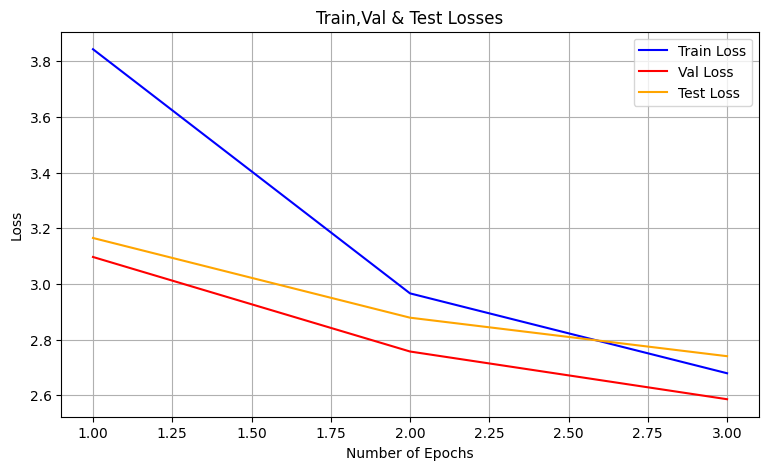

  **************************************** Epoch 4 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:24,  1.36s/it]

Train Epoch: 4 [1/372 (0%)]	Loss: 2.50467


 13%|█▎        | 50/372 [01:11<07:31,  1.40s/it]

Train Epoch: 4 [50/372 (13%)]	Loss: 3.02911


 27%|██▋       | 100/372 [02:21<05:53,  1.30s/it]

Train Epoch: 4 [100/372 (27%)]	Loss: 2.08697


 40%|████      | 150/372 [03:27<04:56,  1.34s/it]

Train Epoch: 4 [150/372 (40%)]	Loss: 3.50297


 54%|█████▍    | 200/372 [04:34<04:18,  1.50s/it]

Train Epoch: 4 [200/372 (53%)]	Loss: 2.92288


 67%|██████▋   | 250/372 [05:52<03:10,  1.56s/it]

Train Epoch: 4 [250/372 (67%)]	Loss: 2.06698


 81%|████████  | 300/372 [07:04<01:36,  1.34s/it]

Train Epoch: 4 [300/372 (80%)]	Loss: 2.44738


 94%|█████████▍| 350/372 [08:12<00:29,  1.36s/it]

Train Epoch: 4 [350/372 (94%)]	Loss: 2.55191


100%|██████████| 372/372 [08:40<00:00,  1.40s/it]


Train Loss: 2.5025 Train Acc: 78.8087%

Validation: 


  1%|          | 1/94 [00:00<00:33,  2.78it/s]

Val Epoch: 4 [1/94 (0%)]	Loss: 2.30383


 53%|█████▎    | 50/94 [00:17<00:15,  2.92it/s]

Val Epoch: 4 [50/94 (52%)]	Loss: 2.77932


100%|██████████| 94/94 [00:34<00:00,  2.71it/s]


Val Loss: 2.4796 Val Acc: 78.7525%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:35<00:00,  2.67it/s]


Test Loss: 2.6709 Acc: 77.0497%


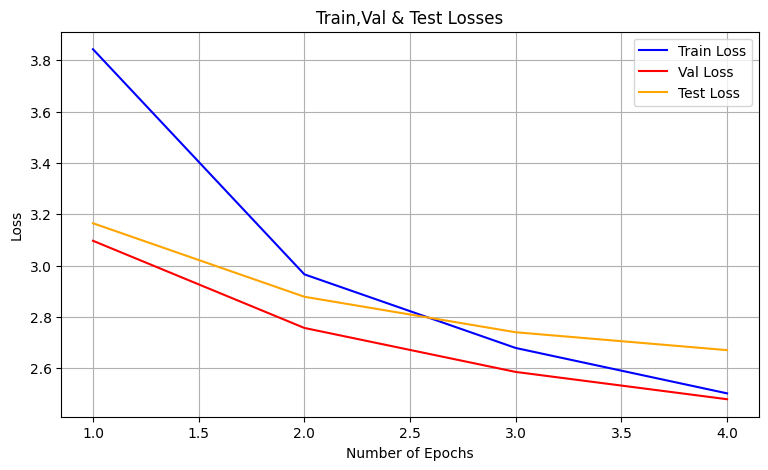

  **************************************** Epoch 5 ******************************************
Train: 


  0%|          | 1/372 [00:01<09:04,  1.47s/it]

Train Epoch: 5 [1/372 (0%)]	Loss: 2.76073


 13%|█▎        | 50/372 [01:11<07:33,  1.41s/it]

Train Epoch: 5 [50/372 (13%)]	Loss: 1.95382


 27%|██▋       | 100/372 [02:20<06:00,  1.33s/it]

Train Epoch: 5 [100/372 (27%)]	Loss: 2.72844


 40%|████      | 150/372 [03:27<05:29,  1.49s/it]

Train Epoch: 5 [150/372 (40%)]	Loss: 2.87809


 54%|█████▍    | 200/372 [04:38<04:03,  1.42s/it]

Train Epoch: 5 [200/372 (53%)]	Loss: 2.30787


 67%|██████▋   | 250/372 [05:49<02:51,  1.41s/it]

Train Epoch: 5 [250/372 (67%)]	Loss: 1.94197


 81%|████████  | 300/372 [07:00<01:47,  1.49s/it]

Train Epoch: 5 [300/372 (80%)]	Loss: 1.65672


 94%|█████████▍| 350/372 [08:12<00:33,  1.53s/it]

Train Epoch: 5 [350/372 (94%)]	Loss: 1.85493


100%|██████████| 372/372 [08:43<00:00,  1.41s/it]


Train Loss: 2.3938 Train Acc: 79.7516%

Validation: 


  1%|          | 1/94 [00:00<00:34,  2.67it/s]

Val Epoch: 5 [1/94 (0%)]	Loss: 1.89819


 53%|█████▎    | 50/94 [00:18<00:15,  2.89it/s]

Val Epoch: 5 [50/94 (52%)]	Loss: 2.76868


100%|██████████| 94/94 [00:33<00:00,  2.83it/s]


Val Loss: 2.3854 Val Acc: 79.4363%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:34<00:00,  2.78it/s]


Test Loss: 2.6137 Acc: 78.0603%


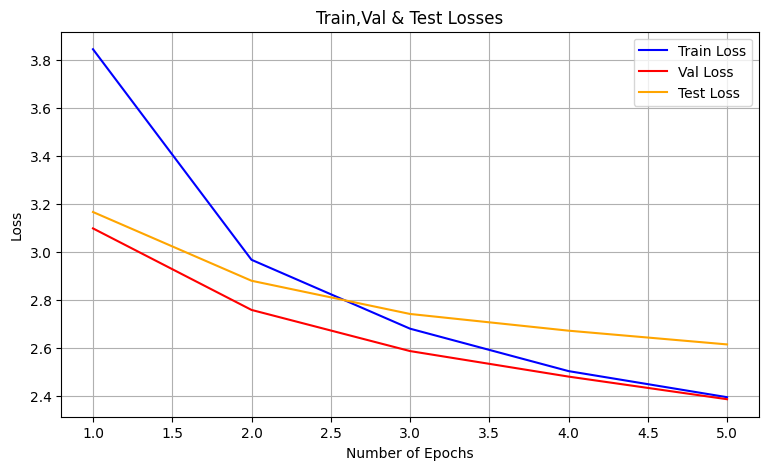

  **************************************** Epoch 6 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:24,  1.36s/it]

Train Epoch: 6 [1/372 (0%)]	Loss: 2.89443


 13%|█▎        | 50/372 [01:09<07:16,  1.35s/it]

Train Epoch: 6 [50/372 (13%)]	Loss: 1.85245


 27%|██▋       | 100/372 [02:16<06:03,  1.34s/it]

Train Epoch: 6 [100/372 (27%)]	Loss: 2.42262


 40%|████      | 150/372 [03:26<05:13,  1.41s/it]

Train Epoch: 6 [150/372 (40%)]	Loss: 2.71442


 54%|█████▍    | 200/372 [04:35<03:47,  1.32s/it]

Train Epoch: 6 [200/372 (53%)]	Loss: 2.80726


 67%|██████▋   | 250/372 [05:45<02:51,  1.40s/it]

Train Epoch: 6 [250/372 (67%)]	Loss: 2.88596


 81%|████████  | 300/372 [06:56<01:40,  1.40s/it]

Train Epoch: 6 [300/372 (80%)]	Loss: 2.43593


 94%|█████████▍| 350/372 [08:10<00:32,  1.47s/it]

Train Epoch: 6 [350/372 (94%)]	Loss: 2.60988


100%|██████████| 372/372 [08:41<00:00,  1.40s/it]


Train Loss: 2.2820 Train Acc: 81.0692%

Validation: 


  1%|          | 1/94 [00:00<00:32,  2.89it/s]

Val Epoch: 6 [1/94 (0%)]	Loss: 1.78392


 53%|█████▎    | 50/94 [00:18<00:16,  2.67it/s]

Val Epoch: 6 [50/94 (52%)]	Loss: 2.14564


100%|██████████| 94/94 [00:33<00:00,  2.78it/s]


Val Loss: 2.3684 Val Acc: 80.0367%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:34<00:00,  2.78it/s]


Test Loss: 2.5978 Acc: 77.8321%


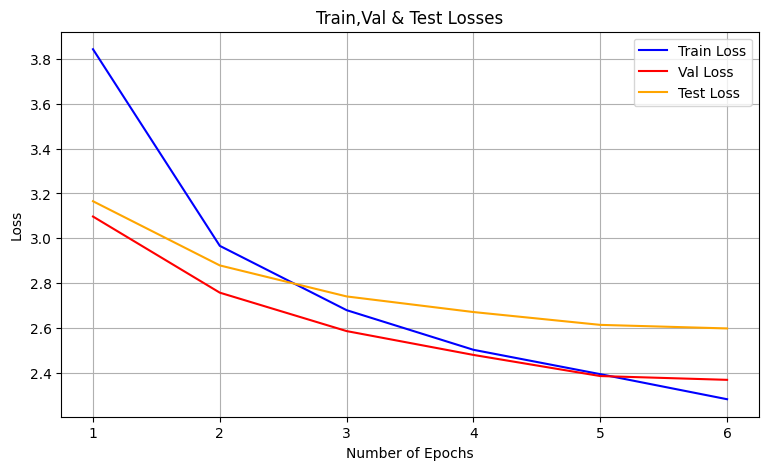

  **************************************** Epoch 7 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:44,  1.41s/it]

Train Epoch: 7 [1/372 (0%)]	Loss: 2.48778


 13%|█▎        | 50/372 [01:11<07:11,  1.34s/it]

Train Epoch: 7 [50/372 (13%)]	Loss: 2.02799


 27%|██▋       | 100/372 [02:22<06:28,  1.43s/it]

Train Epoch: 7 [100/372 (27%)]	Loss: 2.63249


 40%|████      | 150/372 [03:33<05:10,  1.40s/it]

Train Epoch: 7 [150/372 (40%)]	Loss: 1.48867


 54%|█████▍    | 200/372 [04:40<03:48,  1.33s/it]

Train Epoch: 7 [200/372 (53%)]	Loss: 1.90119


 67%|██████▋   | 250/372 [05:46<02:41,  1.33s/it]

Train Epoch: 7 [250/372 (67%)]	Loss: 2.06411


 81%|████████  | 300/372 [06:57<01:43,  1.44s/it]

Train Epoch: 7 [300/372 (80%)]	Loss: 2.66910


 94%|█████████▍| 350/372 [08:08<00:30,  1.38s/it]

Train Epoch: 7 [350/372 (94%)]	Loss: 2.07004


100%|██████████| 372/372 [08:37<00:00,  1.39s/it]


Train Loss: 2.1784 Train Acc: 81.9701%

Validation: 


  1%|          | 1/94 [00:00<00:32,  2.90it/s]

Val Epoch: 7 [1/94 (0%)]	Loss: 2.01162


 53%|█████▎    | 50/94 [00:17<00:15,  2.82it/s]

Val Epoch: 7 [50/94 (52%)]	Loss: 2.62601


100%|██████████| 94/94 [00:33<00:00,  2.78it/s]


Val Loss: 2.3268 Val Acc: 80.1368%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:38<00:00,  2.48it/s]


Test Loss: 2.5592 Acc: 78.3700%


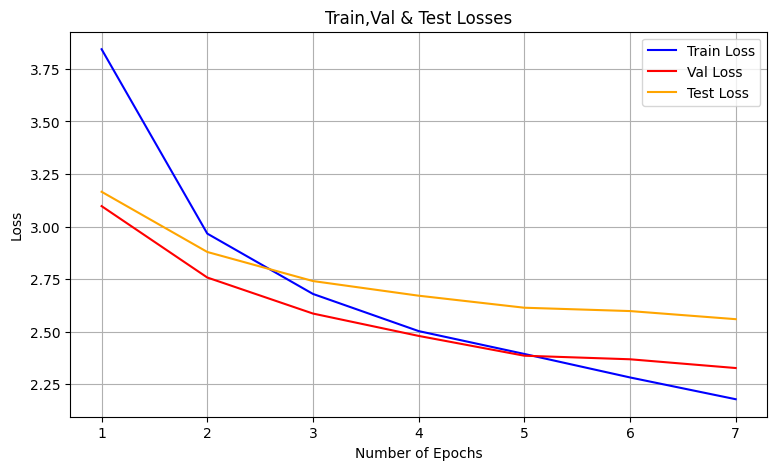

  **************************************** Epoch 8 ******************************************
Train: 


  0%|          | 1/372 [00:01<10:07,  1.64s/it]

Train Epoch: 8 [1/372 (0%)]	Loss: 1.85482


 13%|█▎        | 50/372 [01:11<08:19,  1.55s/it]

Train Epoch: 8 [50/372 (13%)]	Loss: 2.37166


 27%|██▋       | 100/372 [02:23<06:31,  1.44s/it]

Train Epoch: 8 [100/372 (27%)]	Loss: 2.09811


 40%|████      | 150/372 [03:36<05:28,  1.48s/it]

Train Epoch: 8 [150/372 (40%)]	Loss: 1.88196


 54%|█████▍    | 200/372 [04:44<04:05,  1.43s/it]

Train Epoch: 8 [200/372 (53%)]	Loss: 1.76064


 67%|██████▋   | 250/372 [05:55<02:43,  1.34s/it]

Train Epoch: 8 [250/372 (67%)]	Loss: 1.74590


 81%|████████  | 300/372 [07:07<01:41,  1.41s/it]

Train Epoch: 8 [300/372 (80%)]	Loss: 1.47960


 94%|█████████▍| 350/372 [08:23<00:31,  1.43s/it]

Train Epoch: 8 [350/372 (94%)]	Loss: 2.55839


100%|██████████| 372/372 [08:54<00:00,  1.44s/it]


Train Loss: 2.0953 Train Acc: 82.6521%

Validation: 


  1%|          | 1/94 [00:00<00:33,  2.78it/s]

Val Epoch: 8 [1/94 (0%)]	Loss: 2.10133


 53%|█████▎    | 50/94 [00:18<00:15,  2.80it/s]

Val Epoch: 8 [50/94 (52%)]	Loss: 1.77412


100%|██████████| 94/94 [00:33<00:00,  2.78it/s]


Val Loss: 2.2918 Val Acc: 81.0374%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:34<00:00,  2.78it/s]


Test Loss: 2.5355 Acc: 78.3863%


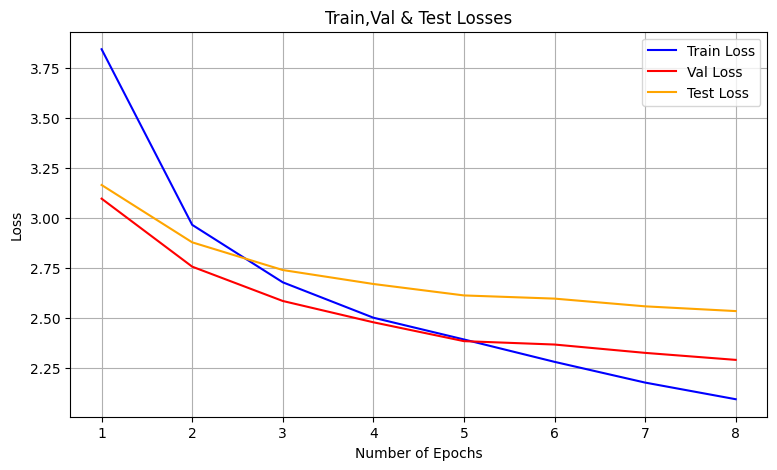

  **************************************** Epoch 9 ******************************************
Train: 


  0%|          | 1/372 [00:01<09:04,  1.47s/it]

Train Epoch: 9 [1/372 (0%)]	Loss: 2.61074


 13%|█▎        | 50/372 [01:08<07:18,  1.36s/it]

Train Epoch: 9 [50/372 (13%)]	Loss: 2.20029


 27%|██▋       | 100/372 [02:17<06:13,  1.37s/it]

Train Epoch: 9 [100/372 (27%)]	Loss: 2.46034


 40%|████      | 150/372 [03:30<05:26,  1.47s/it]

Train Epoch: 9 [150/372 (40%)]	Loss: 2.07594


 54%|█████▍    | 200/372 [04:39<03:54,  1.36s/it]

Train Epoch: 9 [200/372 (53%)]	Loss: 1.80689


 67%|██████▋   | 250/372 [05:47<02:43,  1.34s/it]

Train Epoch: 9 [250/372 (67%)]	Loss: 1.95432


 81%|████████  | 300/372 [06:56<01:40,  1.40s/it]

Train Epoch: 9 [300/372 (80%)]	Loss: 1.76249


 94%|█████████▍| 350/372 [08:09<00:34,  1.59s/it]

Train Epoch: 9 [350/372 (94%)]	Loss: 3.44168


100%|██████████| 372/372 [08:40<00:00,  1.40s/it]


Train Loss: 2.0188 Train Acc: 83.4435%

Validation: 


  1%|          | 1/94 [00:00<00:33,  2.78it/s]

Val Epoch: 9 [1/94 (0%)]	Loss: 1.97678


 53%|█████▎    | 50/94 [00:18<00:15,  2.77it/s]

Val Epoch: 9 [50/94 (52%)]	Loss: 2.69429


100%|██████████| 94/94 [00:33<00:00,  2.80it/s]


Val Loss: 2.2458 Val Acc: 80.9373%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:37<00:00,  2.58it/s]


Test Loss: 2.4913 Acc: 78.7612%


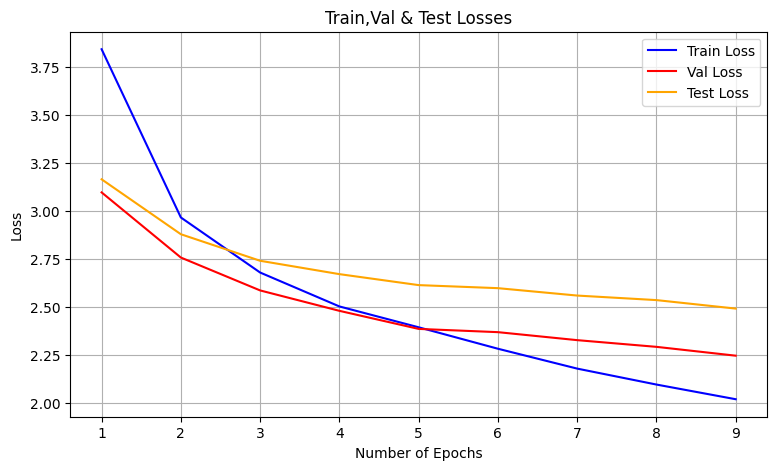

  **************************************** Epoch 10 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:41,  1.41s/it]

Train Epoch: 10 [1/372 (0%)]	Loss: 2.02643


 13%|█▎        | 50/372 [01:12<07:56,  1.48s/it]

Train Epoch: 10 [50/372 (13%)]	Loss: 2.53368


 27%|██▋       | 100/372 [02:25<06:48,  1.50s/it]

Train Epoch: 10 [100/372 (27%)]	Loss: 1.08799


 40%|████      | 150/372 [03:38<05:08,  1.39s/it]

Train Epoch: 10 [150/372 (40%)]	Loss: 2.08555


 54%|█████▍    | 200/372 [04:50<04:00,  1.40s/it]

Train Epoch: 10 [200/372 (53%)]	Loss: 3.14895


 67%|██████▋   | 250/372 [06:02<02:55,  1.44s/it]

Train Epoch: 10 [250/372 (67%)]	Loss: 2.02999


 81%|████████  | 300/372 [07:15<01:49,  1.51s/it]

Train Epoch: 10 [300/372 (80%)]	Loss: 1.69559


 94%|█████████▍| 350/372 [08:24<00:29,  1.36s/it]

Train Epoch: 10 [350/372 (94%)]	Loss: 1.55328


100%|██████████| 372/372 [08:52<00:00,  1.43s/it]


Train Loss: 1.9703 Train Acc: 83.8518%

Validation: 


  1%|          | 1/94 [00:00<00:30,  3.05it/s]

Val Epoch: 10 [1/94 (0%)]	Loss: 2.46899


 53%|█████▎    | 50/94 [00:16<00:14,  2.99it/s]

Val Epoch: 10 [50/94 (52%)]	Loss: 1.50639


100%|██████████| 94/94 [00:31<00:00,  2.97it/s]


Val Loss: 2.2484 Val Acc: 80.6871%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:34<00:00,  2.78it/s]


Test Loss: 2.4894 Acc: 78.9242%


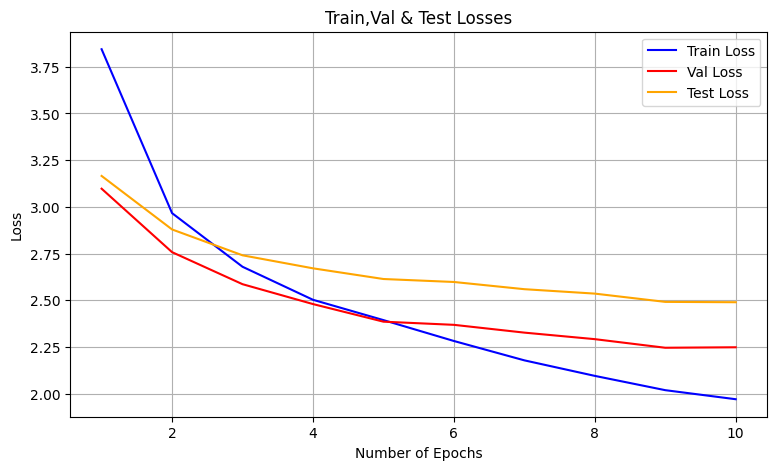

  **************************************** Epoch 11 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:24,  1.36s/it]

Train Epoch: 11 [1/372 (0%)]	Loss: 1.27680


 13%|█▎        | 50/372 [01:13<07:31,  1.40s/it]

Train Epoch: 11 [50/372 (13%)]	Loss: 1.94242


 27%|██▋       | 100/372 [02:25<06:44,  1.49s/it]

Train Epoch: 11 [100/372 (27%)]	Loss: 1.97002


 40%|████      | 150/372 [03:36<05:03,  1.37s/it]

Train Epoch: 11 [150/372 (40%)]	Loss: 1.00283


 54%|█████▍    | 200/372 [04:46<03:48,  1.33s/it]

Train Epoch: 11 [200/372 (53%)]	Loss: 2.05989


 67%|██████▋   | 250/372 [05:58<03:00,  1.48s/it]

Train Epoch: 11 [250/372 (67%)]	Loss: 1.93245


 81%|████████  | 300/372 [07:07<01:34,  1.32s/it]

Train Epoch: 11 [300/372 (80%)]	Loss: 1.72144


 94%|█████████▍| 350/372 [08:12<00:28,  1.30s/it]

Train Epoch: 11 [350/372 (94%)]	Loss: 1.33671


100%|██████████| 372/372 [08:40<00:00,  1.40s/it]


Train Loss: 1.8931 Train Acc: 84.5254%

Validation: 


  1%|          | 1/94 [00:00<00:31,  2.92it/s]

Val Epoch: 11 [1/94 (0%)]	Loss: 2.81649


 53%|█████▎    | 50/94 [00:16<00:14,  2.96it/s]

Val Epoch: 11 [50/94 (52%)]	Loss: 2.02657


100%|██████████| 94/94 [00:31<00:00,  2.96it/s]


Val Loss: 2.2281 Val Acc: 81.2375%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:32<00:00,  2.97it/s]


Test Loss: 2.4909 Acc: 78.7775%


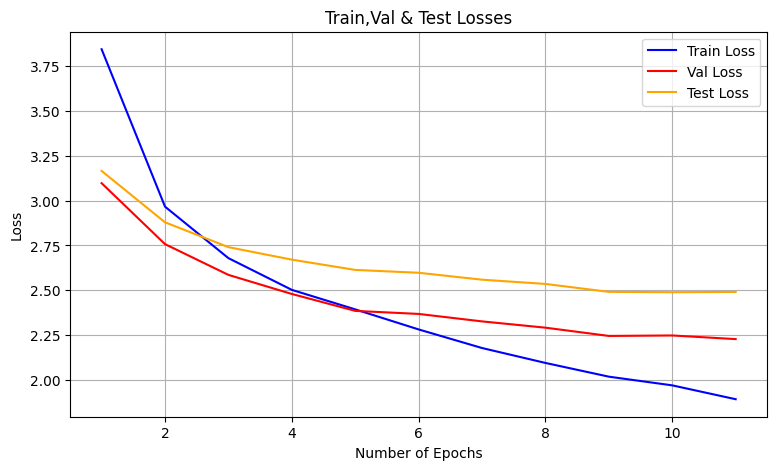

  **************************************** Epoch 12 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:09,  1.32s/it]

Train Epoch: 12 [1/372 (0%)]	Loss: 1.79352


 13%|█▎        | 50/372 [01:05<07:03,  1.31s/it]

Train Epoch: 12 [50/372 (13%)]	Loss: 2.31646


 27%|██▋       | 100/372 [02:11<05:57,  1.31s/it]

Train Epoch: 12 [100/372 (27%)]	Loss: 1.93027


 40%|████      | 150/372 [03:19<04:52,  1.32s/it]

Train Epoch: 12 [150/372 (40%)]	Loss: 1.82500


 54%|█████▍    | 200/372 [04:24<03:46,  1.32s/it]

Train Epoch: 12 [200/372 (53%)]	Loss: 1.96344


 67%|██████▋   | 250/372 [05:30<02:38,  1.30s/it]

Train Epoch: 12 [250/372 (67%)]	Loss: 2.16086


 81%|████████  | 300/372 [06:36<01:34,  1.31s/it]

Train Epoch: 12 [300/372 (80%)]	Loss: 2.28445


 94%|█████████▍| 350/372 [07:41<00:28,  1.29s/it]

Train Epoch: 12 [350/372 (94%)]	Loss: 1.83601


100%|██████████| 372/372 [08:09<00:00,  1.32s/it]


Train Loss: 1.8310 Train Acc: 85.2157%

Validation: 


  1%|          | 1/94 [00:00<00:33,  2.81it/s]

Val Epoch: 12 [1/94 (0%)]	Loss: 2.26009


 53%|█████▎    | 50/94 [00:16<00:14,  2.98it/s]

Val Epoch: 12 [50/94 (52%)]	Loss: 2.51266


100%|██████████| 94/94 [00:31<00:00,  2.96it/s]


Val Loss: 2.2384 Val Acc: 81.0374%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:32<00:00,  2.96it/s]


Test Loss: 2.4686 Acc: 79.1035%


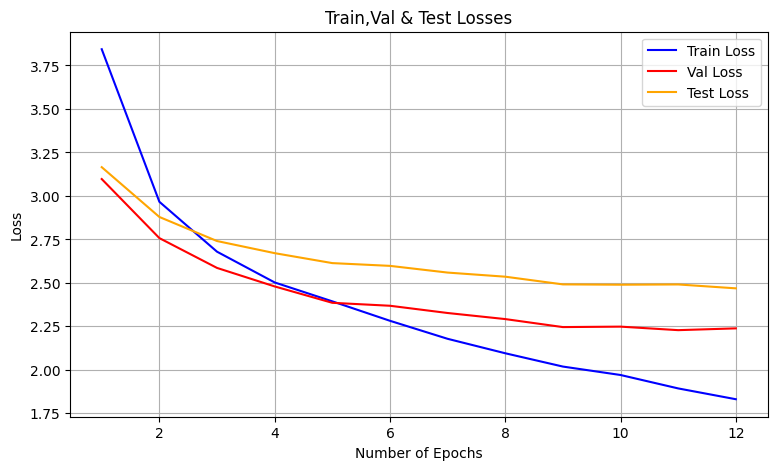

  **************************************** Epoch 13 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:07,  1.31s/it]

Train Epoch: 13 [1/372 (0%)]	Loss: 1.72576


 13%|█▎        | 50/372 [01:05<07:05,  1.32s/it]

Train Epoch: 13 [50/372 (13%)]	Loss: 1.74782


 27%|██▋       | 100/372 [02:12<06:00,  1.32s/it]

Train Epoch: 13 [100/372 (27%)]	Loss: 1.84686


 40%|████      | 150/372 [03:17<04:53,  1.32s/it]

Train Epoch: 13 [150/372 (40%)]	Loss: 1.56654


 54%|█████▍    | 200/372 [04:24<03:49,  1.33s/it]

Train Epoch: 13 [200/372 (53%)]	Loss: 1.44690


 67%|██████▋   | 250/372 [05:30<02:42,  1.33s/it]

Train Epoch: 13 [250/372 (67%)]	Loss: 2.08697


 81%|████████  | 300/372 [06:37<01:36,  1.34s/it]

Train Epoch: 13 [300/372 (80%)]	Loss: 1.10120


 94%|█████████▍| 350/372 [07:44<00:29,  1.33s/it]

Train Epoch: 13 [350/372 (94%)]	Loss: 1.49130


100%|██████████| 372/372 [08:13<00:00,  1.33s/it]


Train Loss: 1.7406 Train Acc: 86.0535%

Validation: 


  1%|          | 1/94 [00:00<00:33,  2.78it/s]

Val Epoch: 13 [1/94 (0%)]	Loss: 2.23868


 53%|█████▎    | 50/94 [00:17<00:15,  2.92it/s]

Val Epoch: 13 [50/94 (52%)]	Loss: 1.44815


100%|██████████| 94/94 [00:32<00:00,  2.92it/s]


Val Loss: 2.2089 Val Acc: 81.2708%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:33<00:00,  2.91it/s]


Test Loss: 2.4550 Acc: 78.9894%


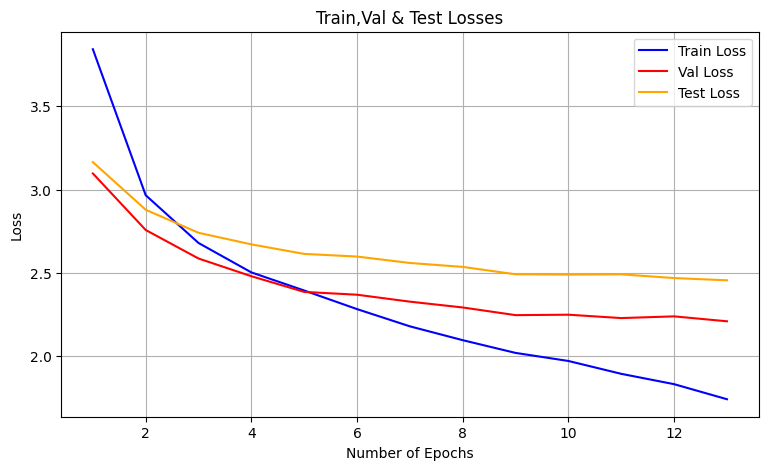

  **************************************** Epoch 14 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:20,  1.35s/it]

Train Epoch: 14 [1/372 (0%)]	Loss: 1.80980


 13%|█▎        | 50/372 [01:08<07:08,  1.33s/it]

Train Epoch: 14 [50/372 (13%)]	Loss: 1.74392


 27%|██▋       | 100/372 [02:14<06:02,  1.33s/it]

Train Epoch: 14 [100/372 (27%)]	Loss: 1.58379


 40%|████      | 150/372 [03:21<04:58,  1.35s/it]

Train Epoch: 14 [150/372 (40%)]	Loss: 1.93943


 54%|█████▍    | 200/372 [04:28<03:49,  1.33s/it]

Train Epoch: 14 [200/372 (53%)]	Loss: 2.68966


 67%|██████▋   | 250/372 [05:34<02:42,  1.33s/it]

Train Epoch: 14 [250/372 (67%)]	Loss: 2.30152


 81%|████████  | 300/372 [06:41<01:35,  1.33s/it]

Train Epoch: 14 [300/372 (80%)]	Loss: 2.03547


 94%|█████████▍| 350/372 [07:48<00:29,  1.34s/it]

Train Epoch: 14 [350/372 (94%)]	Loss: 1.83319


100%|██████████| 372/372 [08:17<00:00,  1.34s/it]


Train Loss: 1.7167 Train Acc: 86.1587%

Validation: 


  1%|          | 1/94 [00:00<00:33,  2.78it/s]

Val Epoch: 14 [1/94 (0%)]	Loss: 2.26011


 53%|█████▎    | 50/94 [00:17<00:15,  2.85it/s]

Val Epoch: 14 [50/94 (52%)]	Loss: 1.91172


100%|██████████| 94/94 [00:32<00:00,  2.85it/s]


Val Loss: 2.1889 Val Acc: 81.3209%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:32<00:00,  2.92it/s]


Test Loss: 2.4343 Acc: 79.7555%


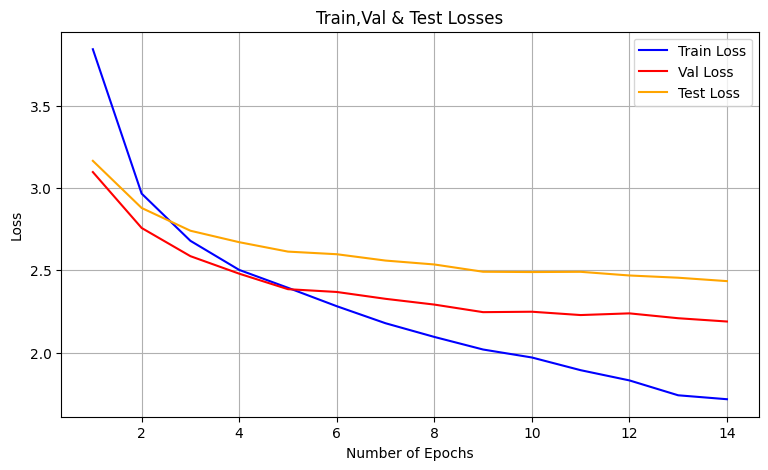

  **************************************** Epoch 15 ******************************************
Train: 


  0%|          | 1/372 [00:01<08:51,  1.43s/it]

Train Epoch: 15 [1/372 (0%)]	Loss: 1.01426


 13%|█▎        | 50/372 [01:08<07:14,  1.35s/it]

Train Epoch: 15 [50/372 (13%)]	Loss: 1.64486


 27%|██▋       | 100/372 [02:15<06:03,  1.34s/it]

Train Epoch: 15 [100/372 (27%)]	Loss: 1.31380


 40%|████      | 150/372 [03:25<05:49,  1.57s/it]

Train Epoch: 15 [150/372 (40%)]	Loss: 1.22646


 54%|█████▍    | 200/372 [04:36<04:01,  1.40s/it]

Train Epoch: 15 [200/372 (53%)]	Loss: 1.26401


 67%|██████▋   | 250/372 [05:46<02:46,  1.36s/it]

Train Epoch: 15 [250/372 (67%)]	Loss: 1.80607


 81%|████████  | 300/372 [06:58<01:37,  1.36s/it]

Train Epoch: 15 [300/372 (80%)]	Loss: 1.94056


 94%|█████████▍| 350/372 [08:06<00:29,  1.35s/it]

Train Epoch: 15 [350/372 (94%)]	Loss: 2.07322


100%|██████████| 372/372 [08:38<00:00,  1.39s/it]


Train Loss: 1.6480 Train Acc: 86.9080%

Validation: 


  1%|          | 1/94 [00:00<00:31,  2.94it/s]

Val Epoch: 15 [1/94 (0%)]	Loss: 2.37284


 53%|█████▎    | 50/94 [00:19<00:17,  2.55it/s]

Val Epoch: 15 [50/94 (52%)]	Loss: 1.99862


100%|██████████| 94/94 [00:37<00:00,  2.52it/s]


Val Loss: 2.2034 Val Acc: 81.4710%
Model saved to DL\model

Test: 


100%|██████████| 96/96 [00:37<00:00,  2.56it/s]


Test Loss: 2.4682 Acc: 79.3806%


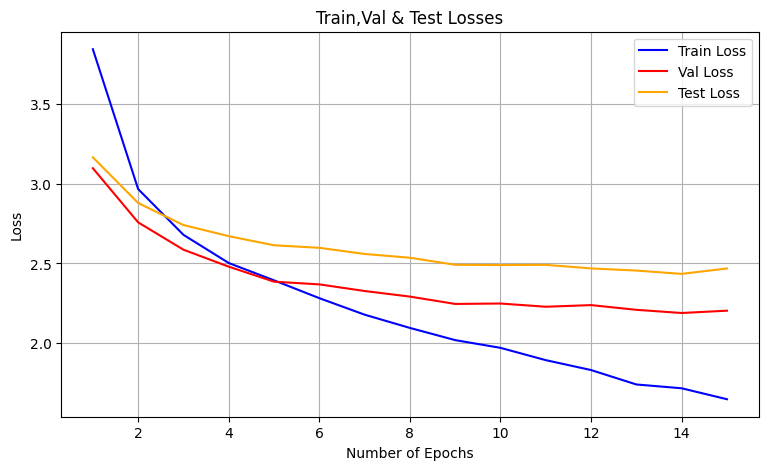

Training complete in 146m 38s
Best Test Acc: 0.797555


In [ ]:
# Training function
def train_model(model, dataloader_train, dataloader_validation, criterion, optimizer, scheduler, num_epochs):
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience = 0
    for epoch in range(1, num_epochs + 1):
        print('  '+'*' * 40 + f' Epoch {epoch} ' + '*' * 42)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            counter_dict[phase].append(epoch)
            if phase == 'train':
                print("Train: ")
                model.train()  # Set model to training mode
                data_loader = tqdm(torch.utils.data.DataLoader(transformed_data_train, batch_size=64, shuffle=True, num_workers=0))
            else:
                print("\nValidation: ")
                model.eval()   # Set model to evaluate mode
                data_loader = tqdm(torch.utils.data.DataLoader(transformed_data_val, batch_size=64, shuffle=True, num_workers=0))

            running_loss = 0.0
            running_corrects = 0

            for i, batch in enumerate(data_loader):
                anch, pos, neg = batch['anchor'], batch['positive'], batch['negative']
                anch, pos, neg = anch.cuda(), pos.cuda(), neg.cuda()

                optimizer.zero_grad()

                # Forward pass
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    out1, out2, out3 = model(anch, pos, neg)

                    # loss = criterion(out1, out2 , labels)
                    distance_positive, distance_negative, loss = criterion(out1, out2, out3)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                running_loss += loss.item() * anch.size(0)
                running_corrects += torch.sum(distance_positive.squeeze() < distance_negative.squeeze())
                if (i+1) % 50 == 0 or i == 0:
                    # print('current loss at batch {}/{} : {:4f} /// {:4f}'.format(i, len(data_loader), loss.item(), loss.item() * img1.size(0)))
                    time_elapsed_now = time.time() - start
                    print('{} Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}'.format(phase.capitalize(),epoch, (i+1), len(data_loader),
                    100. * i / len(data_loader), loss.item()))

            # if phase == 'train':
            #   scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.double() /  dataset_sizes[phase]
            print('{} Loss: {:.4f} {} Acc: {:.4f}%'.format(phase.capitalize(), epoch_loss, phase.capitalize(),epoch_accuracy * 100))

            loss_dict[phase].append(epoch_loss)
            accuracies.append(epoch_accuracy)
        # Save the model after each epoch
        if os.path.exists(model_save_path):
            torch.save(model.state_dict(), os.path.join(model_save_path, f'DL_model_epoch_{epoch}'))
        # torch.save(counter_dict, os.path.join(os.path.join('DL','loss'), f'DL_counter_{epoch}'))
        # torch.save(loss_dict, os.path.join(os.path.join('DL','loss'), f'DL_loss{epoch}'))
        latest = epoch
        print(f'Model saved to {model_save_path}')
        # Test the model
        print("\nTest: ")
        acc_test, loss_test  = test_model(model, criterion)
        counter_dict['test'].append(epoch)
        # deep copy the model
        if acc_test > best_acc:
            best_acc = acc_test
            best_model_wts = copy.deepcopy(model.state_dict())
        if acc_test >= 0.8:
            print("best model has been reached! above 79% acc!")
            plot(loss_dict, counter_dict)
            # load best model weights
            best_val = model
            best_val.load_state_dict(best_model_wts)
            if os.path.exists(model_save_path):
                torch.save(best_val.state_dict(), os.path.join(model_save_path, 'DL_best_model'))
            break
        # Check if test loss has increased for two consecutive epochs
        if loss_dict['test'][epoch - 1] > loss_dict['test'][epoch - 2]:
            patience += 1
            if patience >= 2:
                print("Test loss has increased for two consecutive epochs. Stopping training.")
                loss_dict['train']=loss_dict['train'][:epoch-2]
                loss_dict['test']=loss_dict['test'][:epoch-2]
                loss_dict['val']=loss_dict['val'][:epoch-2]
                counter_dict['train']=counter_dict['train'][:epoch-2]
                counter_dict['test']=counter_dict['test'][:epoch-2]
                counter_dict['val']=counter_dict['val'][:epoch-2]
                print("Best model:")
                plot(loss_dict, counter_dict)
                break
        else:
            patience = 0
        plot(loss_dict, counter_dict)
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # load best model weights
    best_val = model
    best_val.load_state_dict(best_model_wts)
    if os.path.exists(model_save_path):
        torch.save(best_val.state_dict(), os.path.join(model_save_path, 'DL_best_model'))
    return best_val, model

siamese_net.to(device)
best_val, latest_model = train_model(siamese_net, train_dataloader, valid_dataloader, criterion_triplet, optimizer, scheduler,15)

### Best model plots

Best model: Train & Val Losses


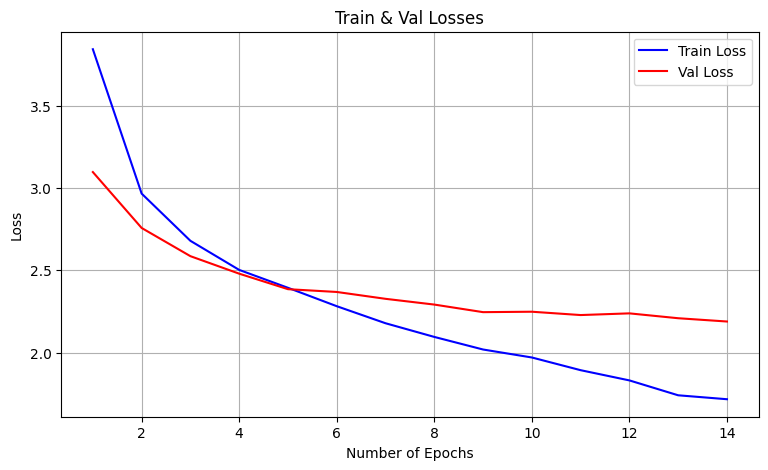

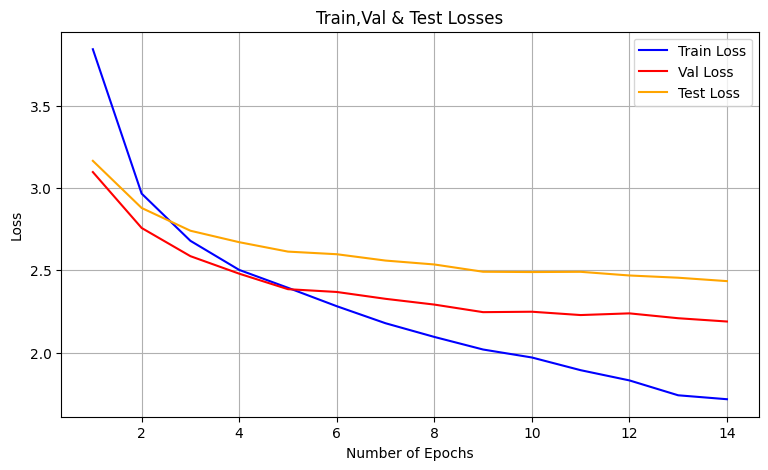

In [ ]:
# new_loss_dict = loss_dict
# new_counter_dict = counter_dict
# new_loss_dict['train']=loss_dict['train'][:14]
# new_loss_dict['test']=loss_dict['test'][:14]
# new_loss_dict['val']=loss_dict['val'][:14]
# new_counter_dict['train']=counter_dict['train'][:14]
# new_counter_dict['test']=counter_dict['test'][:14]
# new_counter_dict['val']=counter_dict['val'][:14]


# print("Best model: Train & Val Losses")
# plot_new(new_loss_dict, new_counter_dict)
# plot(new_loss_dict, new_counter_dict)


## **Test Result**

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Test the model
# Initialize ResNet18 model from torchvision
resnet34 = models.resnet34(pretrained=True)

# Initialize the Siamese Network
siamese_net = SiameseNetwork(resnet34).to(device)
if os.path.exists(model_save_path):
    siamese_net.load_state_dict(torch.load(os.path.join(model_save_path, 'DL_best_model')))
else:
    print("model_save_path does not exist!")
    siamese_net = best_val

acc, loss = test_model(siamese_net, criterion_triplet)

100%|██████████| 96/96 [00:34<00:00,  2.79it/s]


Test Loss: 2.4343 Acc: 79.7555%
